# Preprocessing

## Verify GPU Allocation

In [1]:
!nvidia-smi

Tue Jun  6 01:31:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get Home Location

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Setup Segment Anything and helper tools





In [3]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-mtvkbgus
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-mtvkbgus
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=e320d2a10aed34363693d0e32e89a15517d4d65a9bef8a4f7f70d136ffc46132
  Stored in directory: /tmp/pip-ephem-wheel-cache-dzxnwsv4/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [4]:
!pip install -q jupyter_bbox_widget dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.8 MB/s eta 0:00:00


In [5]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

/content
/content/weights


In [6]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_b_01ec64.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_b_01ec64.pth ; exist: True


## Setup data directory (Images should be added here)

In [7]:
%cd {HOME}
%cd {HOME}/drive/MyDrive/Stanford/Dataset/log_2 # Change to your current working path with input image 
WORKDIR = os.getcwd()

/content
/content/drive/MyDrive/Stanford/Dataset/log_2


In [8]:
import os

IMAGE_NAME = "frame_x.png" #Change to image file name
IMAGE_PATH = os.path.join(WORKDIR, IMAGE_NAME)

# Main Code

## Start segmentation

In [9]:
import torch
import cv2
import supervision as sv

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_b"

In [10]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [11]:
# mask_generator = SamAutomaticMaskGenerator(model=sam)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.98,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

## Load and process image

In [12]:
image_full = cv2.imread(IMAGE_PATH)
image_bgr = image_full[160:720,:]
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [13]:
sam_result = mask_generator.generate(image_rgb)
len(sam_result)

3

## Show segmentation result

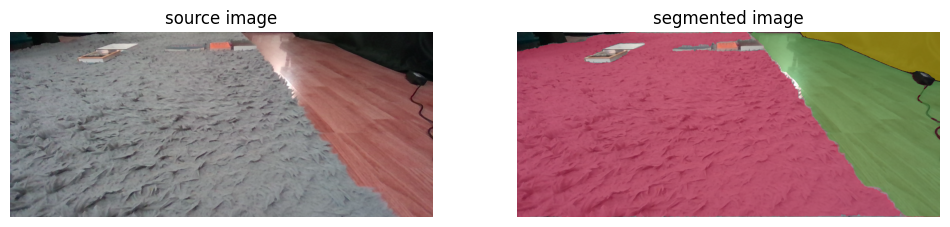

In [14]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [15]:
cv2.imwrite(IMAGE_NAME[:-4]+"_annotated.png", annotated_image)

True

## Find carpet and allocate costs to labels

In [16]:
# find carpet
import numpy as np

carpet_idx = 0
count_list = []

for idx, mask in enumerate(sam_result):
  count = np.count_nonzero(mask['segmentation'])
  print("Found label of size", count)
  count_list.append(count)
  if mask['segmentation'][540][640]:
    carpet_idx = idx

Found label of size 31918
Found label of size 492025
Found label of size 160051


In [17]:
trim_size = 2

main_indices = np.argsort(-np.asarray(count_list))[:trim_size]

In [18]:
rows,cols,_ = image_rgb.shape
low_cost = 50
high_cost = 150
max_cost = 250

# low_cost_img = low_cost * np.ones((rows, cols, 3), dtype = np.uint8)
# high_cost_img = high_cost * np.ones((rows, cols, 3), dtype = np.uint8)
# max_cost_img = max_cost * np.ones((rows, cols, 3), dtype = np.uint8)

In [19]:
result_img = 255*np.ones((rows, cols), dtype = np.uint8)
for idx in main_indices:
  mask = sam_result[idx]['segmentation']
  if carpet_idx == idx:
    masked = low_cost * mask
    result_img += masked.astype('uint8')
  else:
    masked = high_cost * mask
    result_img += masked.astype('uint8')


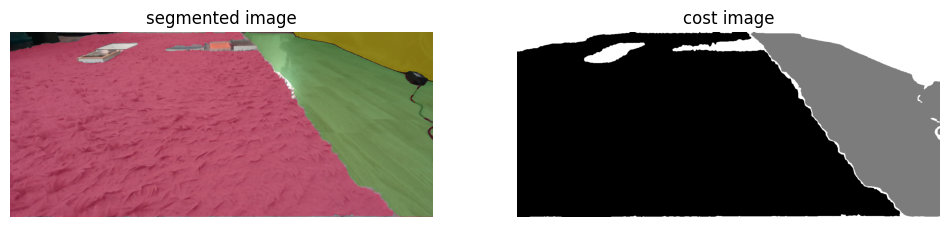

True

In [20]:
sv.plot_images_grid(
    images=[annotated_image, result_img],
    grid_size=(1, 2),
    titles=['segmented image', 'cost image']
)

cv2.imwrite(IMAGE_NAME[:-4]+"_cost.png", result_img)

## Make the BEV Images

In [21]:
# make BEV image

# Define the source points for the perspective transformation
x1, y1 = 0, rows    # bottom left point in image
x2, y2 = 575, 0     # top left
x3, y3 = 739, 0     # top right
x4, y4 = cols, rows  # bottom right

src_points = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])

# Define the output size for the bird's eye view image
measurements = (600, 2220)

output_size = (1900, 2220)  # Specify the desired width and height
factor = output_size[0]-measurements[0]
top_crop = 220

a1, b1 = int(factor/2), measurements[1]
a2, b2 = int(factor/2), 0
a3, b3 = measurements[0]+int(factor/2), 0
a4, b4 = measurements[0]+int(factor/2), measurements[1]

# Define the destination points for the bird's eye view image
dst_points = np.float32([[a1, b1], [a2, b2], [a3, b3], [a4, b4]])

# Compute the perspective transformation matrix
matrix = cv2.getPerspectiveTransform(src_points, dst_points)

In [22]:
bev_image = cv2.warpPerspective(image_bgr, matrix, output_size, cv2.INTER_LINEAR, borderValue=(255, 255, 255))
bev_image = bev_image[top_crop:output_size[1],:]
cv2.imwrite(IMAGE_NAME[:-4]+"_bev.png", bev_image)
bev_image.shape

(2000, 1900, 3)

In [23]:
bev_image_cost = cv2.warpPerspective(result_img, matrix, output_size, cv2.INTER_LINEAR, borderValue=(255, 255, 255))
bev_image_cost = bev_image_cost[top_crop:output_size[1],:]
cv2.imwrite(IMAGE_NAME[:-4]+"_bev_cost.png", bev_image_cost)

True

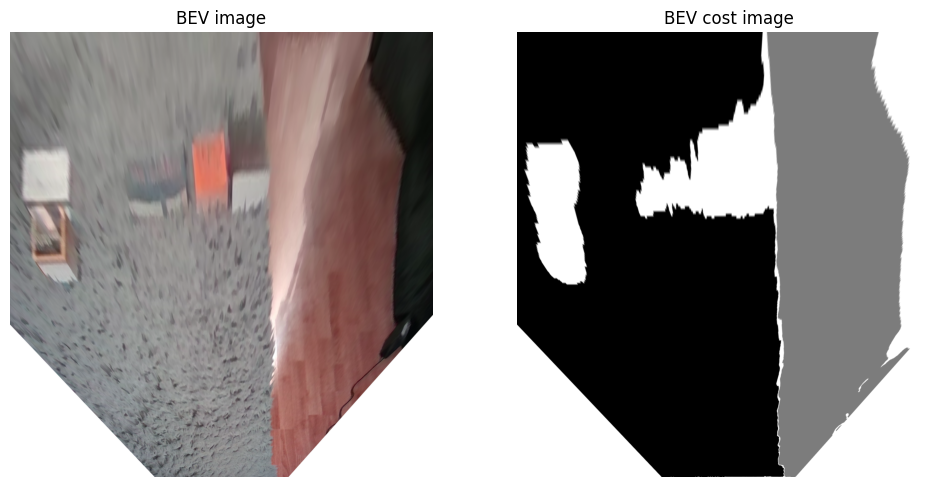

In [24]:
sv.plot_images_grid(
    images=[bev_image, bev_image_cost],
    grid_size=(1, 2),
    titles=['BEV image', 'BEV cost image']
)

## Make cost grid

In [25]:
def split_bev_into_grid(bev_image, grid_size):

  height, width = bev_image.shape
  a, b = grid_size
  
  cell_height = height // a
  cell_width = width // b
  
  # Reshape the BEV image into a grid-like structure
  grid_image = bev_image[:a * cell_height, :b * cell_width]
  grid_image = grid_image.reshape((a, cell_height, b, cell_width))
  
  # Calculate the average cost for each grid cell
  grid = np.mean(grid_image, axis=(1, 3))
  
  return grid

In [26]:
grid_scale = 100 # size of each cell in mm
grid_size = (int(bev_image_cost.shape[0]/grid_scale), int(bev_image_cost.shape[1]/grid_scale))
cost_grid = split_bev_into_grid(bev_image_cost, grid_size)

In [27]:
resized_grid = cv2.resize(cost_grid, (grid_scale*cost_grid.shape[1], grid_scale*cost_grid.shape[0]), interpolation = cv2.INTER_NEAREST )
cv2.imwrite(IMAGE_NAME[:-4]+"_cost_grid.png", resized_grid)

True

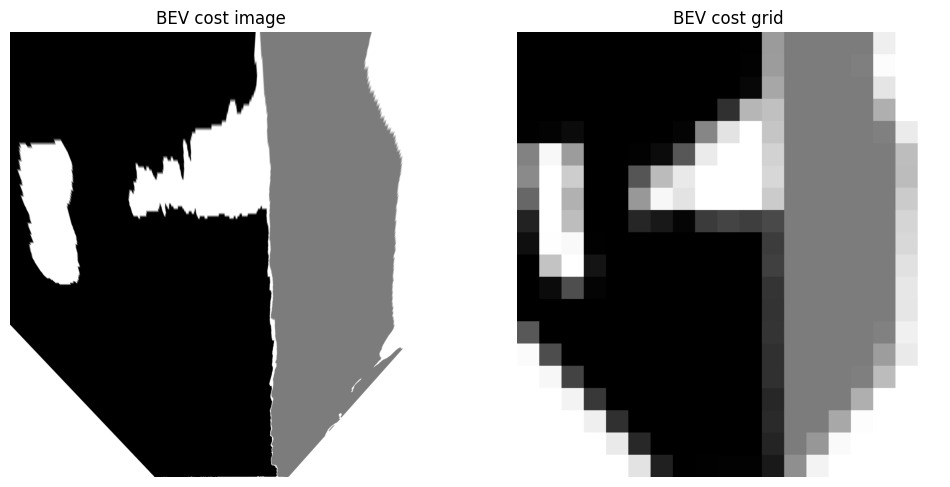

In [28]:
sv.plot_images_grid(
    images=[bev_image_cost, resized_grid],
    grid_size=(1, 2),
    titles=['BEV cost image', 'BEV cost grid']
)

## Set Source and Destination

In [29]:
source = (cost_grid.shape[0]-1,int((cost_grid.shape[1]-1)/2))
destination = (0,int((cost_grid.shape[1]-1)/2))
(source, destination)

((19, 9), (0, 9))

## Create common functions

In [30]:
def get_neighbors(cell, rows, cols):
    row, col = cell
    neighbors = []
    
    if row > 0:
        neighbors.append((row - 1, col))
    if row < rows - 1:
        neighbors.append((row + 1, col)) 
    if col > 0:
        neighbors.append((row, col - 1))  
    if col < cols - 1:
        neighbors.append((row, col + 1))  
    
    return neighbors

def manhattan_distance(cell, destination):
    return abs(cell[0] - destination[0]) + abs(cell[1] - destination[1])

## Define UCS

In [31]:
import numpy as np
import heapq

def uniform_cost_search(grid, source, destination):
    rows, cols = grid.shape
    
    cost_matrix = np.full_like(grid, fill_value=10**8)
    cost_matrix[source[0], source[1]] = 0
    
    queue = [(0, source)]
    
    parent_matrix = np.zeros_like(grid, dtype=np.ndarray)
    parent_matrix[source[0], source[1]] = None
    
    while queue:
        current_cost, current_cell = heapq.heappop(queue)
        
        if current_cell == destination:
            break
        
        neighbors = get_neighbors(current_cell, rows, cols)
        
        for neighbor in neighbors:
            neighbor_cost = current_cost + grid[neighbor[0], neighbor[1]]
            
            if neighbor_cost < cost_matrix[neighbor[0], neighbor[1]]:
                cost_matrix[neighbor[0], neighbor[1]] = neighbor_cost
                parent_matrix[neighbor[0], neighbor[1]] = current_cell
                heapq.heappush(queue, (neighbor_cost, neighbor))
    
    if cost_matrix[destination[0], destination[1]] == np.inf:
        return None
    
    path = []
    current_cell = destination
    
    while current_cell is not None:
        path.append(current_cell)
        current_cell = parent_matrix[current_cell[0], current_cell[1]]
    
    path.reverse()
    
    return path

## Define A-star

In [32]:
import numpy as np
import heapq

def a_star_search(grid, source, destination):
    rows, cols = grid.shape
    
    cost_matrix = np.full_like(grid, fill_value=10**8)
    cost_matrix[source[0], source[1]] = 0
    
    queue = [(0, source)]
    
    parent_matrix = np.zeros_like(grid, dtype=np.ndarray)
    parent_matrix[source[0], source[1]] = None
    
    while queue:
        current_cost, current_cell = heapq.heappop(queue)
        
        if current_cell == destination:
            break
        
        neighbors = get_neighbors(current_cell, rows, cols)
        
        for neighbor in neighbors:
            neighbor_cost = current_cost + grid[neighbor[0], neighbor[1]]
            
            if neighbor_cost < cost_matrix[neighbor[0], neighbor[1]]:
                cost_matrix[neighbor[0], neighbor[1]] = neighbor_cost
                parent_matrix[neighbor[0], neighbor[1]] = current_cell
                total_cost = neighbor_cost + manhattan_distance(neighbor, destination)
                heapq.heappush(queue, (total_cost, neighbor))
    
    if cost_matrix[destination[0], destination[1]] == np.inf:
        return None
    
    path = []
    current_cell = destination
    
    while current_cell is not None:
        path.append(current_cell)
        current_cell = parent_matrix[current_cell[0], current_cell[1]]
    
    path.reverse()
    
    return path

# Perform Search

In [33]:
# # Perform A-star search
%time path = a_star_search(cost_grid, source, destination)

# # Perform uniform cost search
# %time path = uniform_cost_search(cost_grid, source, destination)

# Print the grid and the path
print("\nPath:")
if path:
    for cell in path:
        print(cell)
else:
    print("No path found.")

CPU times: user 2.02 ms, sys: 0 ns, total: 2.02 ms
Wall time: 2.03 ms

Path:
(19, 9)
(18, 9)
(17, 9)
(16, 9)
(15, 9)
(14, 9)
(13, 9)
(12, 9)
(11, 9)
(10, 9)
(9, 9)
(9, 8)
(9, 7)
(9, 6)
(9, 5)
(9, 4)
(8, 4)
(7, 4)
(6, 4)
(5, 4)
(4, 4)
(3, 4)
(2, 4)
(1, 4)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)


# Post Processing

## Create Image with results

In [34]:
int_cost_grid = np.uint8(np.clip(cost_grid, 0, 255))
result_grid = cv2.cvtColor(int_cost_grid,cv2.COLOR_GRAY2RGB)

In [35]:
for y in range(len(result_grid)):
  for x in range(len(result_grid[y])):
    if (y,x) == source:
      result_grid[y][x] = [0,0,255]
    elif (y,x) == destination:
      result_grid[y][x] = [0,255,0] 
    elif (y,x) in path:
      result_grid[y][x] = [255,0,0]
resized_result_grid = cv2.resize(result_grid, (grid_scale*result_grid.shape[0], grid_scale*result_grid.shape[1]), interpolation = cv2.INTER_AREA)
cv2.imwrite(IMAGE_NAME[:-4]+"_cost_grid_search.png", resized_result_grid)

True

In [36]:
# size of the image
(H , W) = cost_grid.shape[0], cost_grid.shape[1]
# Blank image with RGBA = (0, 0, 0, 0)
blank_image = np.full((H, W, 4), (0, 0, 0, 0), np.uint8)
for y in range(len(blank_image)):
  for x in range(len(blank_image[y])):
    if (y,x) == source:
      blank_image[y][x] = [0,0,255,100]
    elif (y,x) == destination:
      blank_image[y][x] = [0,255,0,100] 
    elif (y,x) in path:
      blank_image[y][x] = [255,0,0,100]

resized_blank_grid = cv2.resize(blank_image, (grid_scale*blank_image.shape[1], grid_scale*blank_image.shape[0]), interpolation = cv2.INTER_AREA)

In [37]:
# normalize alpha channels from 0-255 to 0-1
bev_image_color = cv2.cvtColor(bev_image,cv2.COLOR_BGR2BGRA)
alpha_background = bev_image_color[:,:,3] / 255.0
alpha_foreground = resized_blank_grid[:,:,3] / 255.0

# set adjusted colors
for color in range(0, 3):
    bev_image_color[:,:,color] = alpha_foreground * resized_blank_grid[:,:,color] + \
        alpha_background * bev_image_color[:,:,color] * (1 - alpha_foreground)

# set adjusted alpha and denormalize back to 0-255
bev_image_color[:,:,3] = (1 - (1 - alpha_foreground) * (1 - alpha_background)) * 255

# write the image
cv2.imwrite(IMAGE_NAME[:-4]+"_bev_search.png", bev_image_color)

True

In [38]:
inv_matrix = cv2.getPerspectiveTransform(dst_points, src_points)

In [39]:
expanded_blank_grid = np.zeros((output_size[1],output_size[0],4), np.uint8)
expanded_blank_grid[top_crop:output_size[1],:] = resized_blank_grid

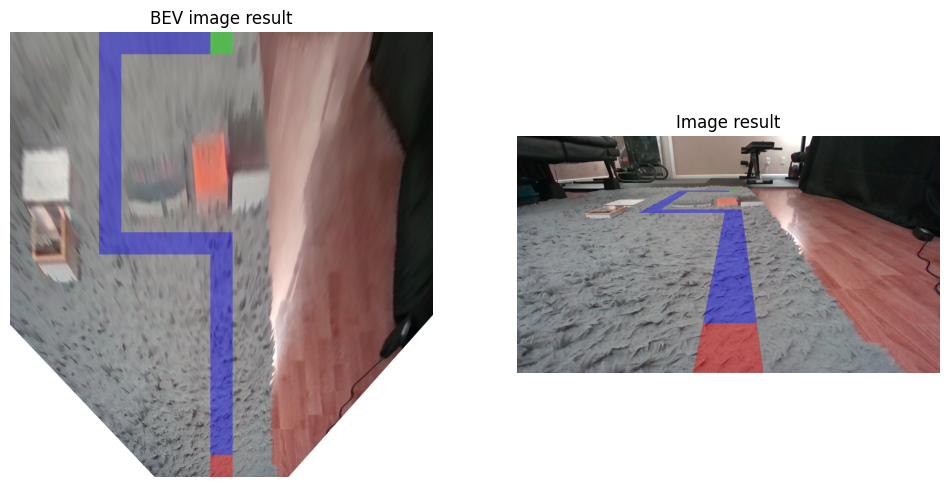

In [40]:
resulting_blank_image = cv2.warpPerspective(expanded_blank_grid, inv_matrix, (1280,560), cv2.INTER_LINEAR, borderValue=(255, 255, 255))

# normalize alpha channels from 0-255 to 0-1
image_color = cv2.cvtColor(image_bgr,cv2.COLOR_BGR2BGRA)
alpha_background = image_color[:,:,3] / 255.0
alpha_foreground = resulting_blank_image[:,:,3] / 255.0

# set adjusted colors
for color in range(0, 3):
    image_color[:,:,color] = alpha_foreground * resulting_blank_image[:,:,color] + \
        alpha_background * image_color[:,:,color] * (1 - alpha_foreground)

# set adjusted alpha and denormalize back to 0-255
image_color[:,:,3] = (1 - (1 - alpha_foreground) * (1 - alpha_background)) * 255

cv2.imwrite(IMAGE_NAME[:-4]+"_search.png", image_color)

image_result = image_full.copy()
image_result[160:720,:] = image_color[:,:,:3]
cv2.imwrite(IMAGE_NAME[:-4]+"_result.png", image_result)

# display the image
sv.plot_images_grid(
    images=[bev_image_color, image_result],
    grid_size=(1, 2),
    titles=['BEV image result', 'Image result']
)